# Test of Exponential Diode: VS-R-Diode in series

In [1]:
import sys
import subprocess
build_path = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8') + '/build'
sys.path.append(build_path)
sys.path

['/home/mto/dpsim/examples/Notebooks/Circuits',
 '/usr/lib64/python39.zip',
 '/usr/lib64/python3.9',
 '/usr/lib64/python3.9/lib-dynload',
 '',
 '/home/mto/.local/lib/python3.9/site-packages',
 '/usr/local/lib64/python3.9/site-packages',
 '/usr/local/lib/python3.9/site-packages',
 '/usr/local/lib/python3.9/site-packages/scipy-1.10.0-py3.9-linux-x86_64.egg',
 '/usr/local/lib/python3.9/site-packages/pandas-1.5.3-py3.9-linux-x86_64.egg',
 '/usr/local/lib/python3.9/site-packages/chevron-0.14.0-py3.9.egg',
 '/usr/local/lib/python3.9/site-packages/xmltodict-0.13.0-py3.9.egg',
 '/usr/lib64/python3.9/site-packages',
 '/usr/lib/python3.9/site-packages',
 '/home/mto/dpsim/build']

## Setup Simulation

In [2]:
import villas.dataprocessing.readtools as rt
from villas.dataprocessing.timeseries import *
from villas.dataprocessing.timeseries import TimeSeries as ts
import matplotlib.pyplot as plt
import numpy as np
import dpsimpy
import re
import os

%matplotlib widget

#Define simulation scenario
time_step = 0.0001
final_time = 0.1
simName = "EMT_Ph1_VS_R1_ExponentialDiode"

dpsimpy.Logger.set_log_dir('logs/' + simName)

#Nodes
gnd = dpsimpy.emt.SimNode.gnd
n1 = dpsimpy.emt.SimNode("n1", dpsimpy.PhaseType.Single)
n2 = dpsimpy.emt.SimNode("n2", dpsimpy.PhaseType.Single)


#Components
vs = dpsimpy.emt.ph1.VoltageSource("vs")
vs.set_parameters(complex(1.,0.), 50.0);

load = dpsimpy.emt.ph1.Resistor("r1")
load.set_parameters(10.0)

expDiode = dpsimpy.emt.ph1.ExponentialDiode("ExponentialDiode");
expDiode.set_parameters(1.0e-12, 25.852e-3);


#Topology
vs.connect([gnd, n1]);
load.connect([n1, n2]);
expDiode.connect([n2, gnd]);

sys = dpsimpy.SystemTopology(50, [n1, n2], [vs, load, expDiode])

#Logging
logger = dpsimpy.Logger(simName)
logger.log_attribute("I_ExponentialDiode", "i_intf", expDiode)
logger.log_attribute("V_ExponentialDiode", "v_intf", expDiode)
logger.log_attribute("V_Resistor", "v_intf", load)
logger.log_attribute("I_Resistor", "i_intf", load)
logger.log_attribute("V_VS", "v_intf", vs)

# Simulation
sim = dpsimpy.Simulation(simName)
sim.set_system(sys)
sim.set_time_step(time_step)
sim.set_final_time(final_time)
sim.set_domain(dpsimpy.Domain.EMT)
sim.set_solver(dpsimpy.Solver.ITERATIVEMNA)
sim.add_logger(logger)
sim.run()

[11:20:29.402655 EMT_Ph1_VS_R1_ExponentialDiode_Solver warning] Linear solver configuration is not used!


## Read and visualize results

column number: 5
results length: 1001
real column names: ['I_ExponentialDiode', 'I_Resistor', 'V_ExponentialDiode', 'V_Resistor', 'V_VS']
complex column names: []


Text(0, 0.5, 'Current [A]')

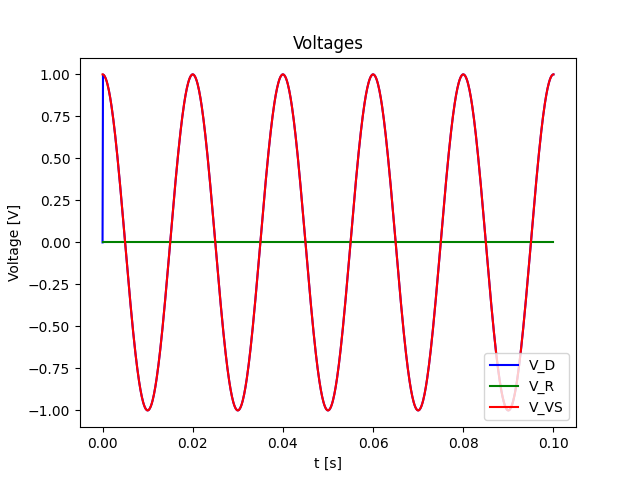

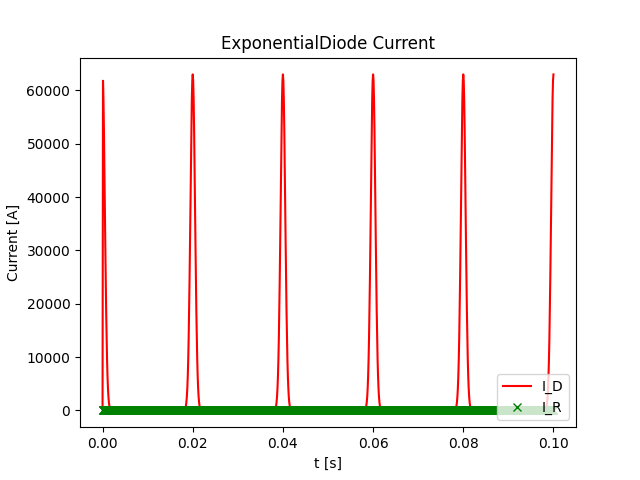

In [3]:
path_logfile = os.getcwd() + "/logs/" + simName + '/' + simName + '.csv'
ts_dpsim_EMT = rt.read_timeseries_dpsim(path_logfile)

plt.close('all')
fig1 = plt.figure()

plt.plot(ts_dpsim_EMT['V_ExponentialDiode'].time, ts_dpsim_EMT['V_ExponentialDiode'].values, "b-", label='V_D')
plt.plot(ts_dpsim_EMT['V_Resistor'].time, ts_dpsim_EMT['V_Resistor'].values, "g-", label='V_R')
plt.plot(ts_dpsim_EMT['V_VS'].time, ts_dpsim_EMT['V_VS'].values, "r-", label='V_VS')

plt.legend(loc = 4)

plt.title('Voltages')
plt.xlabel('t [s]')
plt.ylabel('Voltage [V]')

fig2 = plt.figure()

plt.plot(ts_dpsim_EMT['I_ExponentialDiode'].time, ts_dpsim_EMT['I_ExponentialDiode'].values, "r-", label='I_D')
plt.plot(ts_dpsim_EMT['I_Resistor'].time, ts_dpsim_EMT['I_Resistor'].values, "gx", label='I_R')

plt.legend(loc = 4)

plt.title('ExponentialDiode Current')
plt.xlabel('t [s]')
plt.ylabel('Current [A]')

## Validate against Simulink simulation

### Import Simulink results

In [5]:
import os
import urllib.request

if not os.path.exists('reference-results'):
    os.mkdir('reference-results')

url = 'https://raw.githubusercontent.com/MarvinTollnitschRWTH/reference-results/refs/heads/master/Simulink/Circuits/SL_ExpDiode.csv'
local_file = 'reference-results/SL_ExpDiode.csv'
urllib.request.urlretrieve(url, local_file) 

ts_sl_expDiode = rt.read_timeseries_simulink(local_file)

column number: 2
results length: 1001
real column names: ['ExpDiode_V', 'ExpDiode_I']
complex column names: []


### Plot dpsim against Simulink

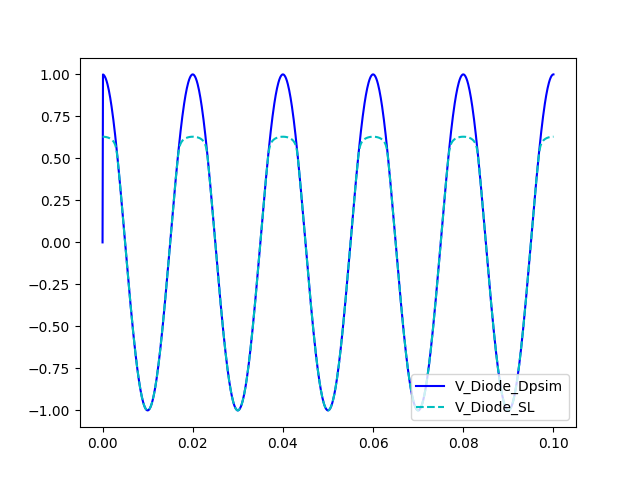

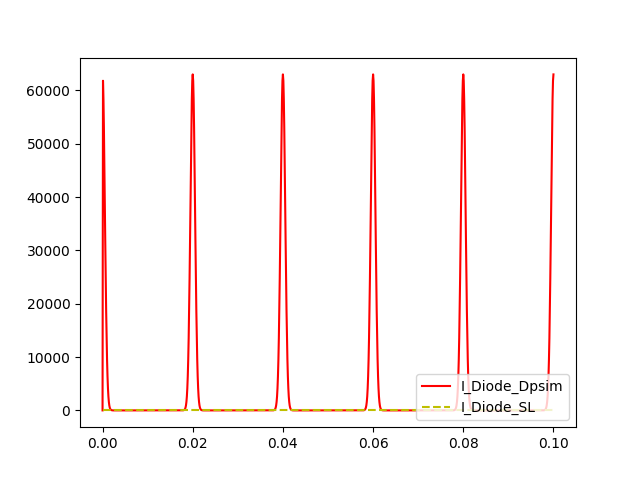

In [6]:
fig3 = plt.figure()

plt.plot(ts_dpsim_EMT['V_ExponentialDiode'].time, ts_dpsim_EMT['V_ExponentialDiode'].values, "b-", label='V_Diode_Dpsim')
plt.plot(ts_sl_expDiode['ExpDiode_V'].time, ts_sl_expDiode['ExpDiode_V'].values, "c--", label='V_Diode_SL')

plt.legend(loc = 4)


fig4 = plt.figure()

plt.plot(ts_dpsim_EMT['I_ExponentialDiode'].time, ts_dpsim_EMT['I_ExponentialDiode'].values, "r-", label='I_Diode_Dpsim')
plt.plot(ts_sl_expDiode['ExpDiode_I'].time, ts_sl_expDiode['ExpDiode_I'].values, "y--", label='I_Diode_SL')

plt.legend(loc = 4)

### Assertion

In [ ]:
epsilon = 1e-100

assert(np.max(ts_dpsim_EMT['V_ExponentialDiode'].values-ts_sl_expDiode['ExpDiode_I'].values) < epsilon)
assert(np.max(ts_dpsim_EMT['I_ExponentialDiode'].values-ts_sl_expDiode['ExpDiode_I'].values) < epsilon)